# Analyzing Call Targets

## Setup

In [1]:
# Load libraries

import matplotlib.pyplot as plt
import pandas as pd
from typing import *

%config InlineBackend.figure_format='png'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Configure pyplot: enlarge plots
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pyplot: set larger font
plt.rcParams.update({'font.size': 10})
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)
# Font for paper
plt.rc('font', family='serif')

In [2]:
all_calls = pd.read_csv(
    "resolved-calls/cross_crate_calls.csv",
    names=[
        "receiver",
        "receiver_generics",
        "target",
        "target_type_generics",
        "target_function_generics",
        "caller_crate",
        "target_crate",
        "macro",
        "count",
    ],
    keep_default_na=False,
    dtype=str,
)
all_calls["count"] = all_calls["count"].astype(int)
all_calls


,receiver,receiver_generics,target,target_type_generics,target_function_generics,caller_crate,target_crate,macro,count
0,,,&[T]::align_to,u8,"(usize, usize)",standback,core,,1
1,,,&[T]::align_to,T,U,bytemuck,core,,6
2,,,&[T]::align_to,u8,u64,snap,core,,1
3,,,&[T]::align_to_mut,T,U,bytemuck,core,,6
4,,,&[T]::align_to_mut,u8,u32,actix_http,core,,2
5,,,&[T]::align_to_mut,u8,u64,rdrand,core,,2
6,,,&[T]::align_to_mut,u8,u32,tungstenite,core,,3
7,,,&[T]::as_mut_ptr,half::binary16::f16,,half,core,,1
8,,,&[T]::as_mut_ptr,core::num::wrapping::Wrapping<i16>,,rand,core,,32
9,,,&[T]::as_mut_ptr,u8,,rand_core,core,,93


In [3]:
all_calls.sort_values(by="count", ascending=False)

,receiver,receiver_generics,target,target_type_generics,target_function_generics,caller_crate,target_crate,macro,count
230206,,,quote::__private::push_ident,,,serde_derive,quote,quote::quote,68909
69605,T,,core::default::Default::default,,,tinyvec,core,,52140
219521,,,libsecp256k1_core::field::FieldStorage::new,,,libsecp256k1,libsecp256k1_core,,34816
229543,,,quote::__private::push_colon2,,,serde_derive,quote,quote::quote,30653
227346,,,proc_macro2::TokenStream::new,,,serde_derive,proc_macro2,quote::quote,23825
61290,<A as de::SeqAccess<'_>>::Error,,core::convert::From::from,<A as de::SeqAccess<'_>>::Error,,serde,core,core::macros::try,20512
88459,,,core::fmt::builders::DebugStruct::field,,,syn,core,,20330
219528,,,libsecp256k1_core::group::AffineStorage::new,,,libsecp256k1,libsecp256k1_core,,17408
230025,,,quote::__private::push_group,,,serde_derive,quote,quote::quote,17076
227126,,,proc_macro2::Span::call_site,,,syn,proc_macro2,,11375


In [4]:
# combine entries past a certain rank into "x others"
def cut_off_after_top(count: int, counts: pd.DataFrame) -> int:
	cutoff = counts['count'][count - 1] # preserve top entries up to here
	dropped_count = len(counts) - count
	counts.loc[f"{dropped_count} others"] = counts[counts['count'] < cutoff].sum()
	counts.drop(counts[counts['count'] < cutoff].index, inplace=True)

In [5]:
# group by the given columns, summing the counts for any combined entries
def sum_counts(frame, columns: List[str]) -> pd.DataFrame:
	frame = frame.groupby(columns)['count'].sum().sort_values(ascending=False).to_frame()
	frame.reset_index(inplace=True)
	return frame

In [6]:
from_calls = all_calls[all_calls['target'] == 'core::convert::From::from']
from_counts = sum_counts(from_calls, ['target_type_generics', 'receiver', 'receiver_generics'])

for from_generics, receiver, receiver_generics, count in from_counts.values[:20]:
	if from_generics == receiver: continue
	r_generics = f"<{receiver_generics}>" if receiver_generics else ""
	print(f"{count}x From<{from_generics}>::from on {receiver}{r_generics}")

2388x From<proc_macro::Punct>::from on proc_macro::TokenTree
2388x From<u8>::from on u32
1598x From<proc_macro::Ident>::from on proc_macro::TokenTree
1449x From<u32>::from on u64
1356x From<u8>::from on usize
1318x From<u16>::from on u32
929x From<proc_macro::TokenTree>::from on proc_macro::TokenStream
816x From<u8>::from on u16
708x From<u8>::from on u64
682x From<&str>::from on alloc::string::String
596x From<proc_macro2::TokenStream>::from on proc_macro::TokenStream
446x From<u32>::from on i64


In [7]:
pin_calls = all_calls[all_calls['target'] == 'core::pin::Pin<P>::new_unchecked']
pin_counts = sum_counts(pin_calls, ['target_type_generics', 'caller_crate'])

for pin_generics, caller_crate, count in pin_counts.values[:20]:
	if pin_generics == receiver: continue
	r_generics = f"<{receiver_generics}>" if receiver_generics else ""
	print(f"{count}x Pin<{pin_generics}>::new from {caller_crate}")

2836x Pin<&core::marker::PhantomPinned>::new from tokio
2546x Pin<&St>::new from futures_util
1620x Pin<&core::option::Option<Fut>>::new from futures_util
1253x Pin<&R>::new from tokio
1103x Pin<&W>::new from tokio
417x Pin<&tokio::future::poll_fn::PollFn<$fn>>::new from tokio
381x Pin<&Fut>::new from futures_util
354x Pin<&futures_util::stream::stream::fuse::Fuse<St>>::new from futures_util
300x Pin<&S>::new from futures_lite
298x Pin<&impl std::future::Future<Output = std::result::Result<(), std::io::Error>>>::new from tokio
288x Pin<&futures_util::future::maybe_done::MaybeDone<Fut2>>::new from futures_util
288x Pin<&futures_util::future::try_maybe_done::TryMaybeDone<Fut1>>::new from futures_util
288x Pin<&futures_util::future::try_maybe_done::TryMaybeDone<Fut2>>::new from futures_util
288x Pin<&futures_util::future::maybe_done::MaybeDone<Fut1>>::new from futures_util
284x Pin<&F>::new from tokio
271x Pin<&tokio::sync::batch_semaphore::Acquire>::new from tokio
256x Pin<&impl std::fut

In [41]:
size_of_calls = all_calls[all_calls['target'] == 'core::mem::size_of']
size_of_counts = sum_counts(size_of_calls, ['target_function_generics'])

print(f"total: {size_of_counts['count'].sum()}")
for generics, count in size_of_counts.values[:20]:
	print(f"{count}x size_of::<{generics}>")

total: 27319
3050x size_of::<u32>
2674x size_of::<u64>
2028x size_of::<i32>
2002x size_of::<u16>
1889x size_of::<i64>
1843x size_of::<u128>
1835x size_of::<i16>
1779x size_of::<i128>
1548x size_of::<usize>
1179x size_of::<u8>
1107x size_of::<i8>
1095x size_of::<isize>
935x size_of::<f64>
933x size_of::<f32>
630x size_of::<T>
284x size_of::<libc::unix::linux_like::linux::gnu::cmsghdr>
129x size_of::<A>
117x size_of::<B>
95x size_of::<V>
88x size_of::<bytes::bytes_mut::BytesMut>


In [42]:
3050 + 2674 + 2028 + 2002 + 1889 + 1843 + 1835 + 1779 + 1548 + 1179 + 1107 + 1095 + 935 + 933

23897

In [9]:
index_calls = all_calls[all_calls['target'] == 'core::ops::index::Index::index']
index_counts = sum_counts(index_calls, ['target_type_generics'])

for row in sum_counts(index_calls, ['target_type_generics']).values[:20]:
	print(row)

#for receiver, generics, count in index_counts.values[:20]:
#	print(f"{count}x {receiver}.index<{generics}>")

['usize' 14609]
['core::ops::range::RangeFrom<usize>' 14165]
['core::ops::range::RangeFull' 8220]
['core::ops::range::RangeTo<usize>' 6294]
['core::ops::range::Range<usize>' 5423]
['(usize, usize)' 263]
['cranelift_codegen::ir::entities::Inst' 224]
['cranelift_codegen::ir::entities::Block' 155]
['core::ops::range::RangeToInclusive<usize>' 138]
['core::ops::range::RangeInclusive<usize>' 134]
['pulldown_cmark::tree::TreeIndex' 89]
['cranelift_codegen::machinst::abi::Sig' 88]
['regalloc::data_structures::BlockIx' 67]
['cranelift_bforest::Node' 60]
['cranelift_codegen::ir::entities::Value' 60]
['I' 55]
['h2::proto::streams::store::Key' 55]
['u8' 55]
['&str' 53]
['wasmparser::validator::types::TypeId' 51]


In [10]:
for row in sum_counts(index_calls, ['receiver']).values[:20]:
	print(row)

['alloc::vec::Vec' 11386]
['[u8]' 9685]
['str' 9054]
['alloc::string::String' 1722]
['pathfinder_simd::scalar::F32x4' 1158]
['pathfinder_simd::scalar::I32x4' 1144]
['syn::punctuated::Punctuated' 930]
['[u8; 8]' 927]
['[u8; 4]' 802]
['[u8; 2]' 687]
['[u8; 16]' 608]
['[u8; 32]' 517]
['nalgebra::base::matrix::Matrix' 481]
['smallvec::SmallVec' 347]
['curve25519_dalek::backend::serial::u64::scalar::Scalar52' 291]
['[u8; 1]' 290]
['[T]' 287]
['cranelift_entity::map::SecondaryMap' 248]
['alloc::collections::vec_deque::VecDeque' 233]
['[u8; 64]' 232]


In [11]:
wrapping_calls = all_calls[all_calls['receiver'] == 'core::num::wrapping::Wrapping']
sum_counts(wrapping_calls, ['caller_crate'])

,caller_crate,count
0,rand,471
1,jpeg_decoder,402
2,rand_isaac,274
3,ring,175
4,polyval,112
5,gimli,100
6,futures_util,84
7,wide,74
8,crossbeam_channel,54
9,rand_xorshift,41


In [12]:
progress_csv = (
    pd.read_csv(
        "spec_progress.csv",
        header=0,
        index_col=False,
        names=["receiver", "target", "reason"],
        dtype=str,
        comment="#",
    )
    .dropna(how="all")
	.fillna("")
)
progress_csv

,receiver,target,reason
0,core::result::Result,core::ops::try_trait::Try::branch,
1,core::result::Result,core::ops::try_trait::FromResidual::from_residual,
2,core::option::Option,core::ops::try_trait::Try::branch,
3,core::option::Option,core::ops::try_trait::FromResidual::from_residual,
4,*,core::clone::Clone::clone,
5,T,core::default::Default::default,
6,,core::option::Option<T>::is_some,
7,,core::option::Option<T>::is_none,
8,,core::option::Option<T>::as_ref,refs
9,,core::option::Option<T>::as_mut,refs


In [13]:
progress = {}
used_progress = set()

for (receiver, call_target, reason) in progress_csv.values:
	if not call_target: continue
	key = (receiver, call_target)
	if key in progress:
		raise Exception(f"Duplicate entry for {key}")
	progress[key] = reason

def _get_progress(receiver: str, call_target: str, macro: str) -> Optional[str]:
	key = (receiver, call_target)
	try:
		result = progress[key]
		used_progress.add(key)
		return result or "complete"
	except KeyError:
		if macro:
			return "macro"
		else:
			return None

# if incomplete, returns string listing future features necessary for complete specification
def progress_for(receiver: str, call_target: str, macro: str) -> str:
	return _get_progress(receiver, call_target, macro) or _get_progress("*", call_target, macro) or "unknown"

#progress
#progress_for("core.option.Option", "core.option.Option.unwrap")
#progress_for("", "core.option.implement.as_ref")
#progress_for("$other.Param", "core.clone.Clone.clone")

In [14]:
def get_progress(row):
	return progress_for(row['receiver'], row['target'], row['macro'])

counts_with_progress = sum_counts(all_calls, ['receiver', 'target', 'macro'])
counts_with_progress["progress"] = counts_with_progress.apply(get_progress, axis=1)
counts_with_progress = sum_counts(counts_with_progress, ['receiver', 'target', 'progress'])
counts_with_progress.to_csv("counts_with_progress.csv", index=False)
counts_with_progress

,receiver,target,progress,count
0,core::result::Result,core::ops::try_trait::Try::branch,complete,212445
1,core::result::Result,core::ops::try_trait::FromResidual::from_residual,complete,207464
2,,quote::__private::push_ident,macro,144911
3,,core::fmt::Arguments::new_v1,useless,83666
4,,core::fmt::Formatter::write_str,useless,81786
5,,proc_macro2::TokenStream::new,macro,69578
6,,core::fmt::ArgumentV1::new_display,useless,66725
7,,quote::__private::push_colon2,macro,56674
8,T,core::default::Default::default,complete,54533
9,,quote::__private::push_group,macro,42423


In [15]:
progress_csv_with_usage = progress_csv.copy()
progress_csv_with_usage["used"] = progress_csv_with_usage.apply(lambda row: (row["receiver"], row["target"]) in used_progress, axis=1)
progress_csv_with_usage.to_csv("spec_progress_with_usage.csv", index=False)

In [16]:
progress_tally = sum_counts(counts_with_progress, ["progress"])
progress_tally.set_index('progress', inplace=True)
print(f"total: {progress_tally.sum()}")
progress_tally

total: count    4317981
dtype: int64


,count
progress,
unknown,1446605
macro,798915
complete,784679
useless,646968
iterators,159054
planned,128606
builtin,108067
calls,87946
interior_mutability,84627


<AxesSubplot: >

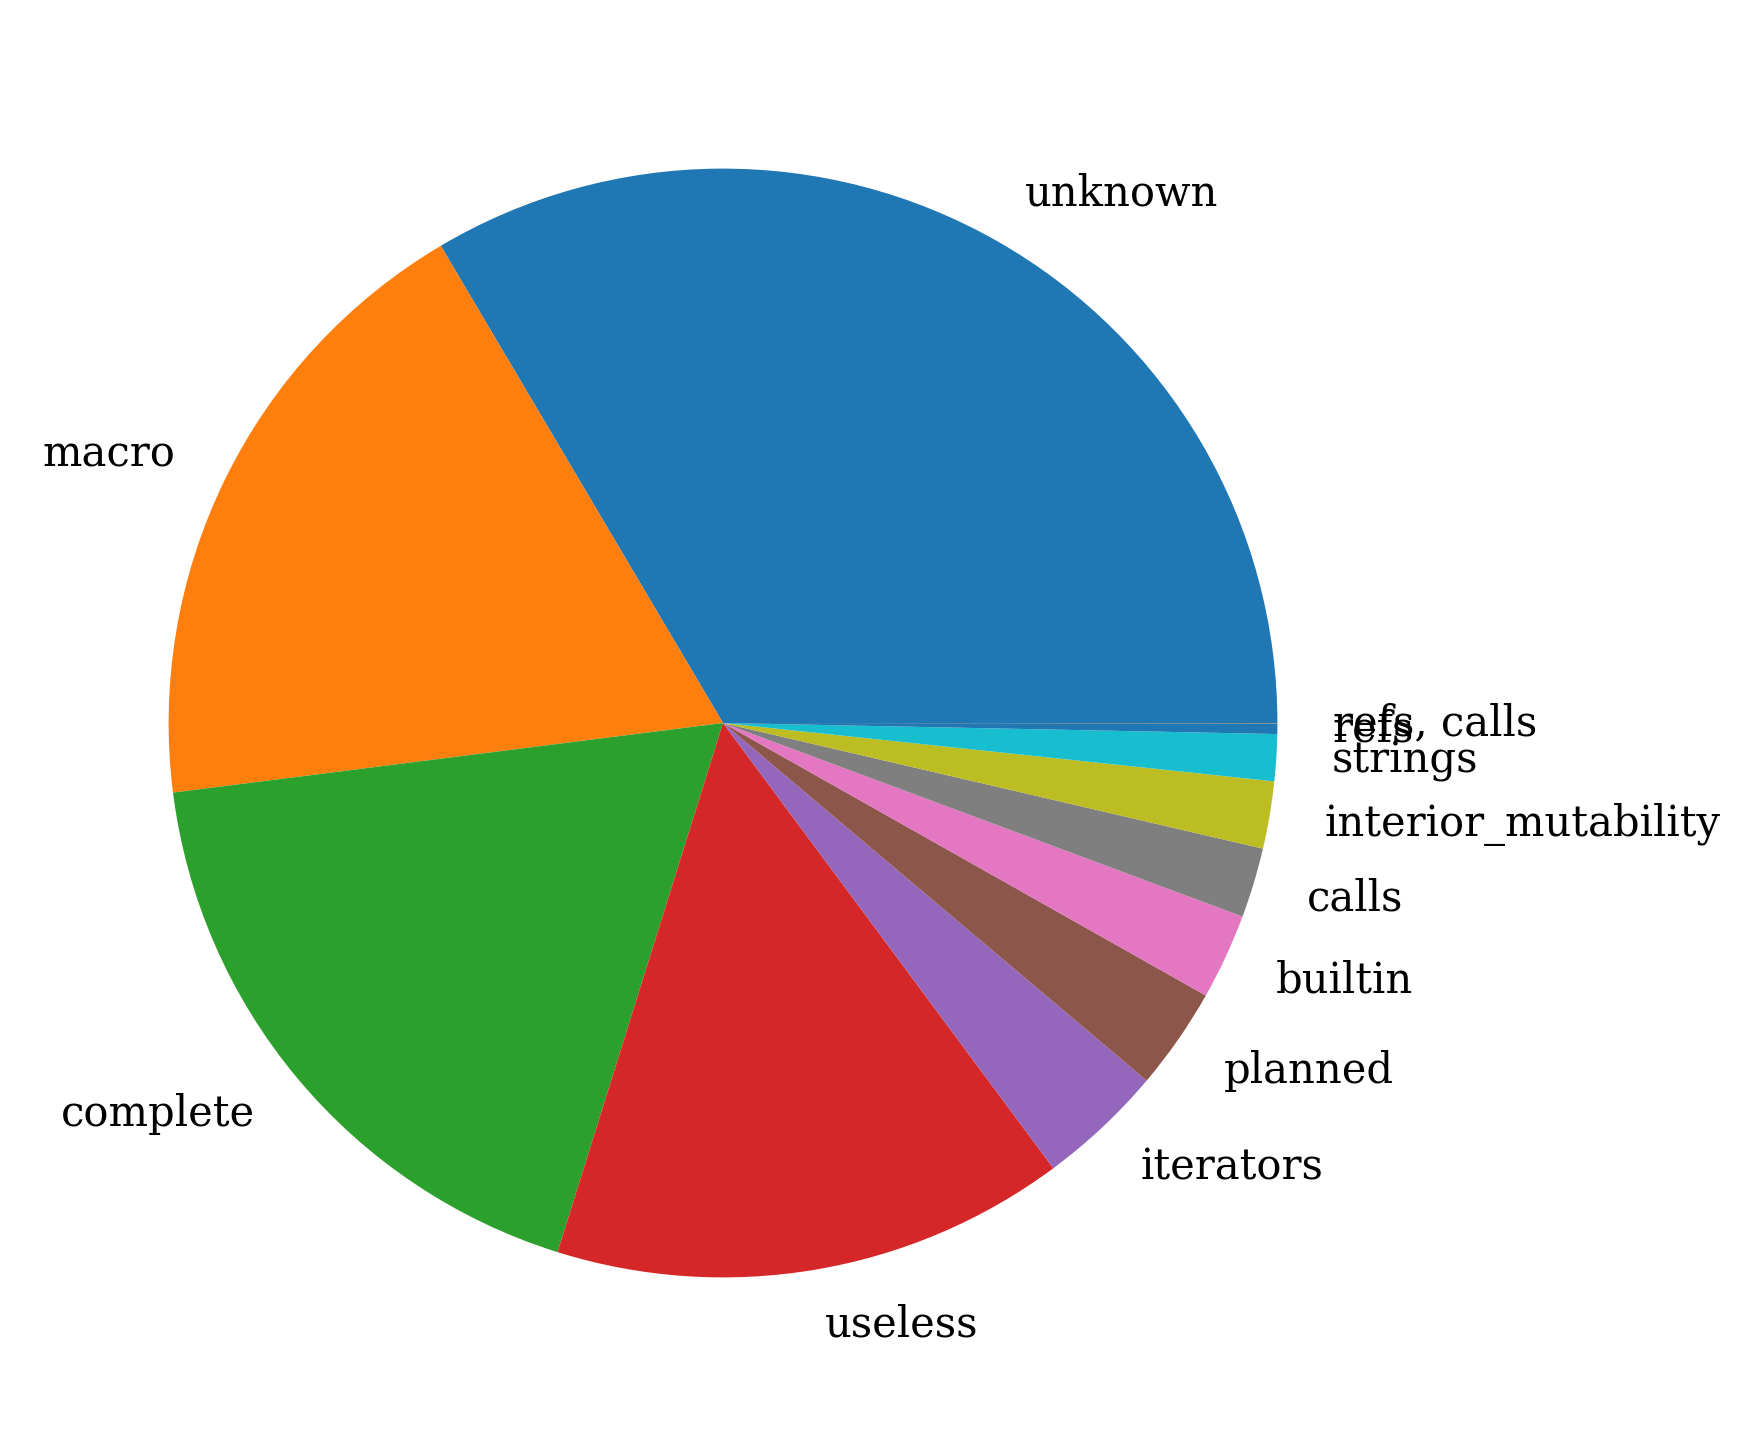

In [17]:
# don't label axes
progress_tally.plot(kind='pie', y='count', figsize=(8, 6), legend=False, ylabel='')

In [18]:
macro_counts = sum_counts(all_calls, ['macro']).copy()
for (macro, count) in macro_counts.values[:20]:
	print(f"{count}x {macro}")

2841676x 
447039x quote::quote
105968x core::fmt::macros::Debug
105425x tracing::macros::trace
70257x core::macros::write
64421x core::clone::Clone
52532x alloc::macros::format
50056x tracing::macros::debug
49824x quote::quote_spanned
45924x bitflags::bitflags
33944x pin_project_lite::pin_project
32984x core::macros::try
29246x std::macros::panic
27330x core::cmp::PartialEq
25208x ruc::eg
24879x serde_derive::Deserialize
17976x log::macros::trace
17355x core::macros::debug_assert
17086x alloc::macros::vec
16561x std::macros::println


<AxesSubplot: title={'center': 'Top Macros by Usage'}>

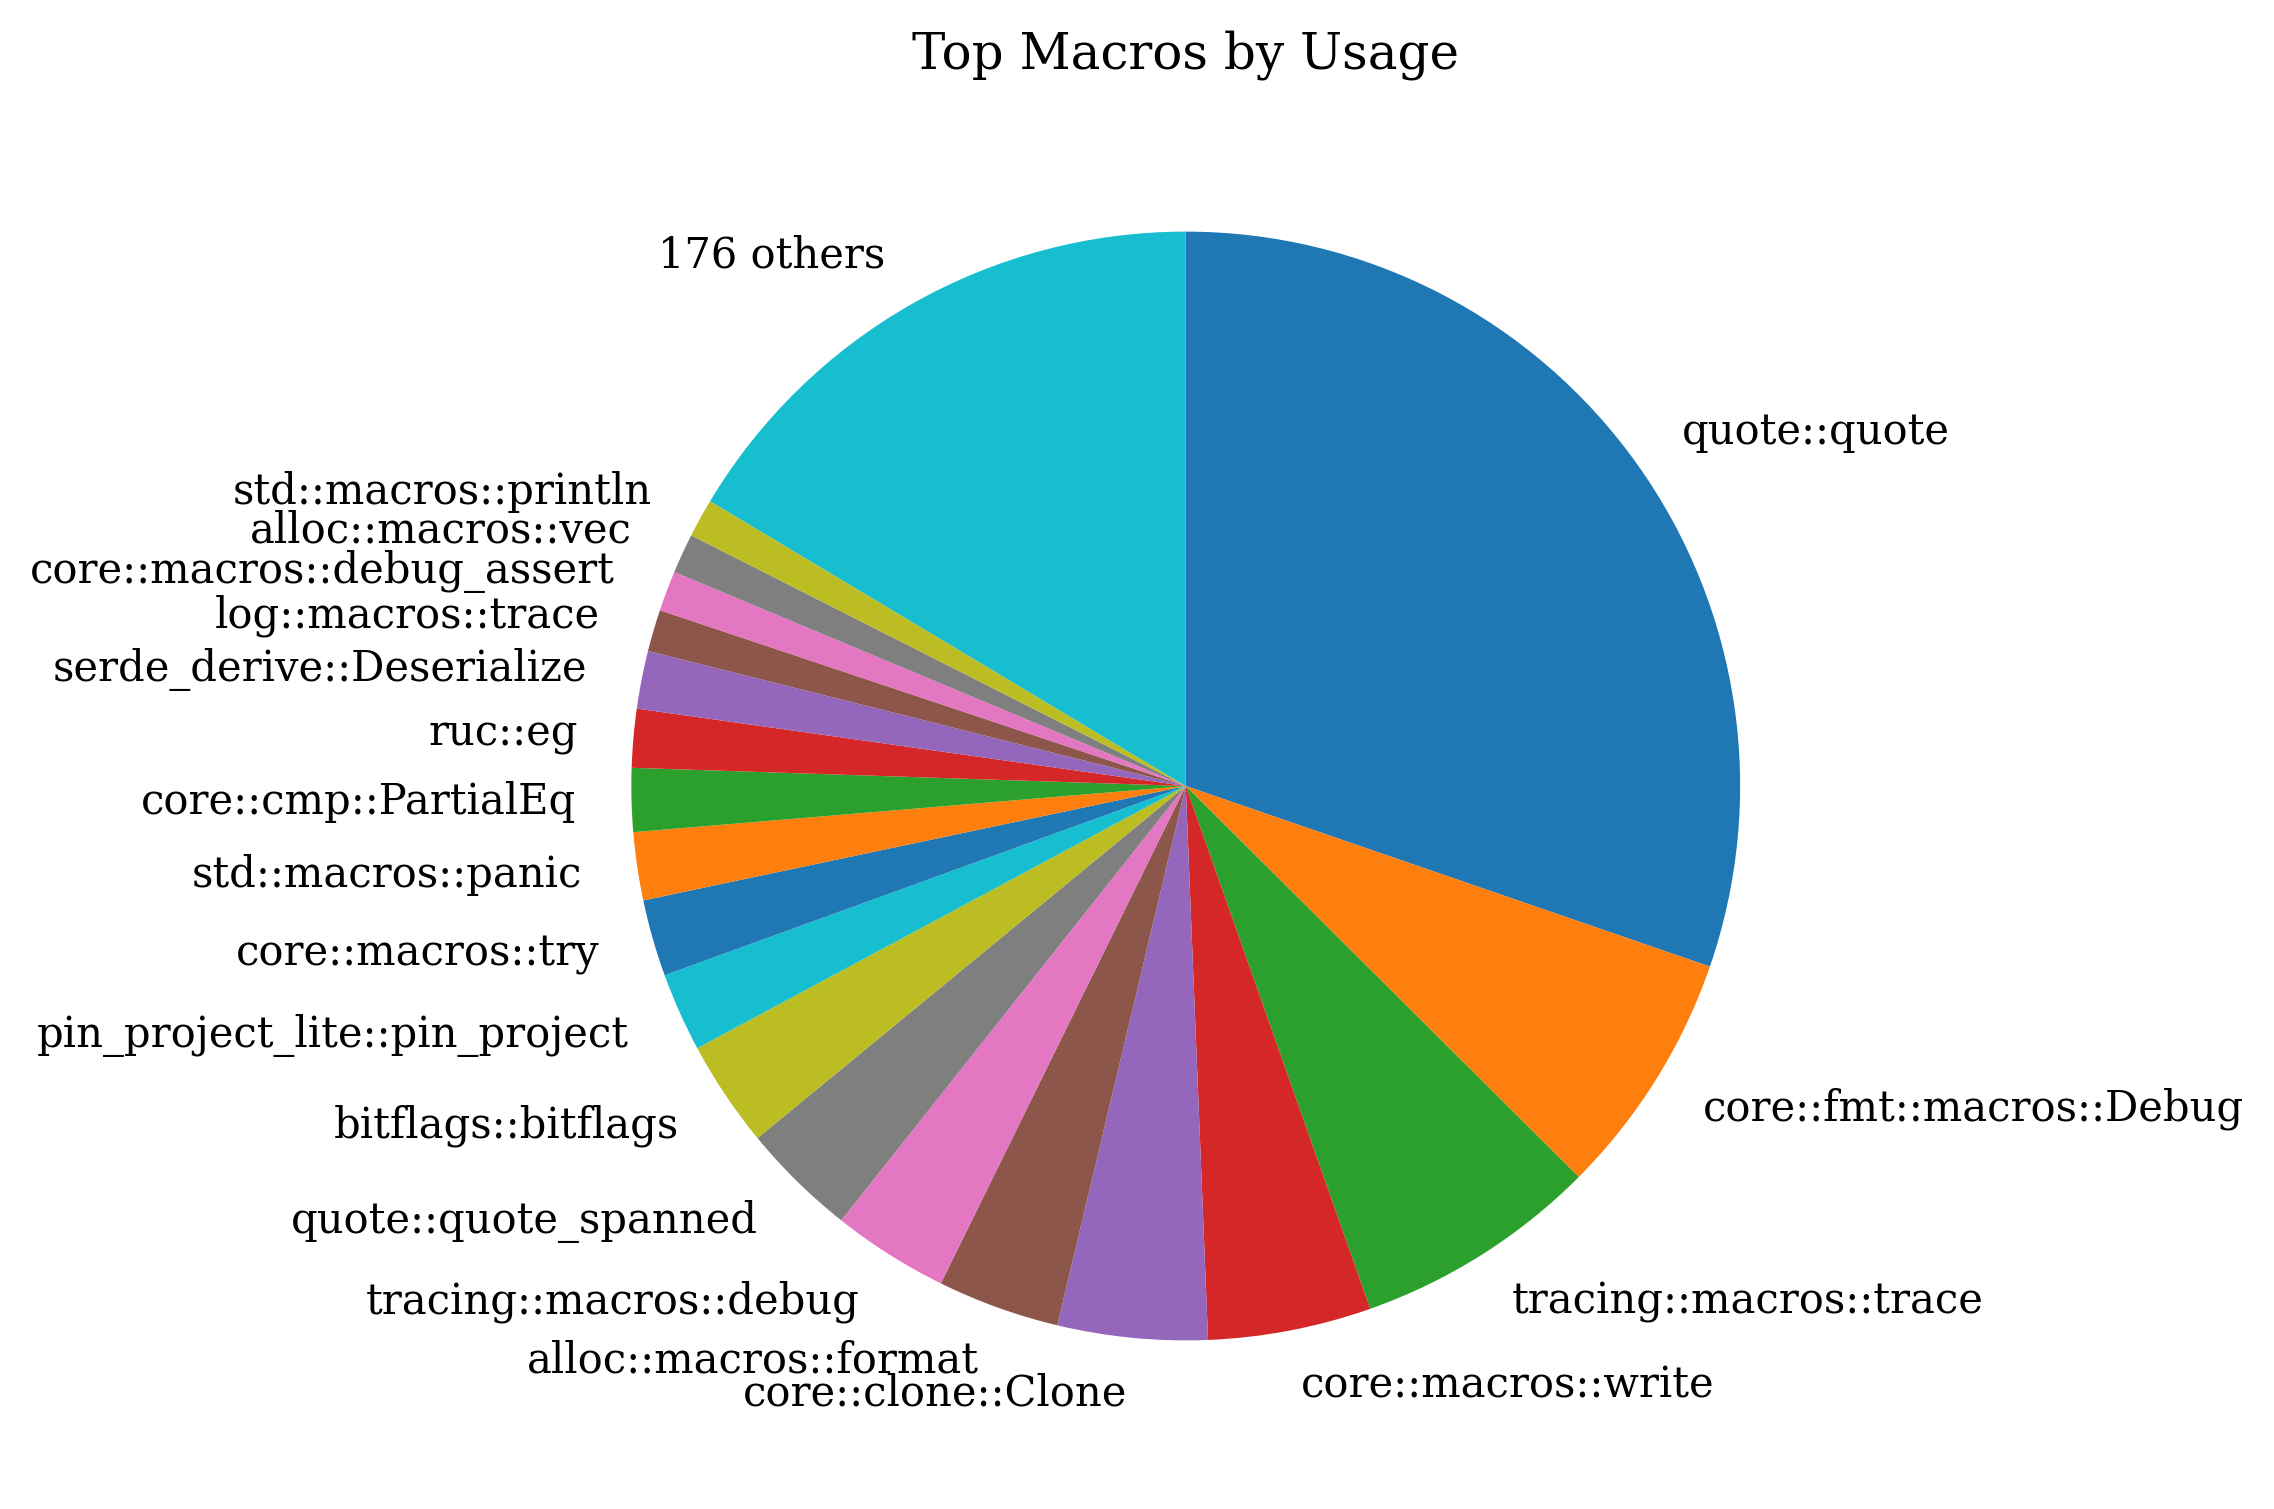

In [19]:
top_macro_counts = macro_counts.copy()
top_macro_counts.set_index('macro', inplace=True)
top_macro_counts.drop([""], inplace=True)
cut_off_after_top(19, top_macro_counts)

top_macro_counts.plot(kind='pie', y='count', figsize=(8, 6), legend=False, ylabel='', startangle=90, counterclock=False, title="Top Macros by Usage")

In [20]:
all_calls[all_calls["macro"] == "ruc::eg"]

,receiver,receiver_generics,target,target_type_generics,target_function_generics,caller_crate,target_crate,macro,count
10942,,,alloc::boxed::Box<T>::new,ruc::err::SimpleError<alloc::string::String>,,vsdb,alloc,ruc::eg,3125
11424,,,alloc::boxed::Box<T>::new,ruc::err::SimpleError<alloc::string::String>,,btm,alloc,ruc::eg,12
11686,,,alloc::boxed::Box<T>::new,ruc::err::SimpleError<alloc::string::String>,,vsdb_core,alloc,ruc::eg,14
13757,,,alloc::fmt::format,,,btm,alloc,ruc::eg,12
13780,,,alloc::fmt::format,,,vsdb_core,alloc,ruc::eg,14
14004,,,alloc::fmt::format,,,vsdb,alloc,ruc::eg,3125
74273,,,core::fmt::ArgumentV1::new_display,,&str,vsdb,core,ruc::eg,3123
75618,,,core::fmt::ArgumentV1::new_display,,core::fmt::Arguments,vsdb,core,ruc::eg,3125
76423,,,core::fmt::ArgumentV1::new_display,,core::fmt::Arguments,vsdb_core,core,ruc::eg,14
77279,,,core::fmt::ArgumentV1::new_display,,u64,vsdb,core,ruc::eg,2


In [35]:
def compute_totals(cumulative: pd.DataFrame):
	sum = 0
	total = cumulative['count'].sum()
	for i in cumulative.index:
		sum += cumulative.loc[i, "count"]
		cumulative.loc[i, "total"] = sum / total

cumulative_counts = sum_counts(all_calls, ['target', 'receiver']).copy()
compute_totals(cumulative_counts)

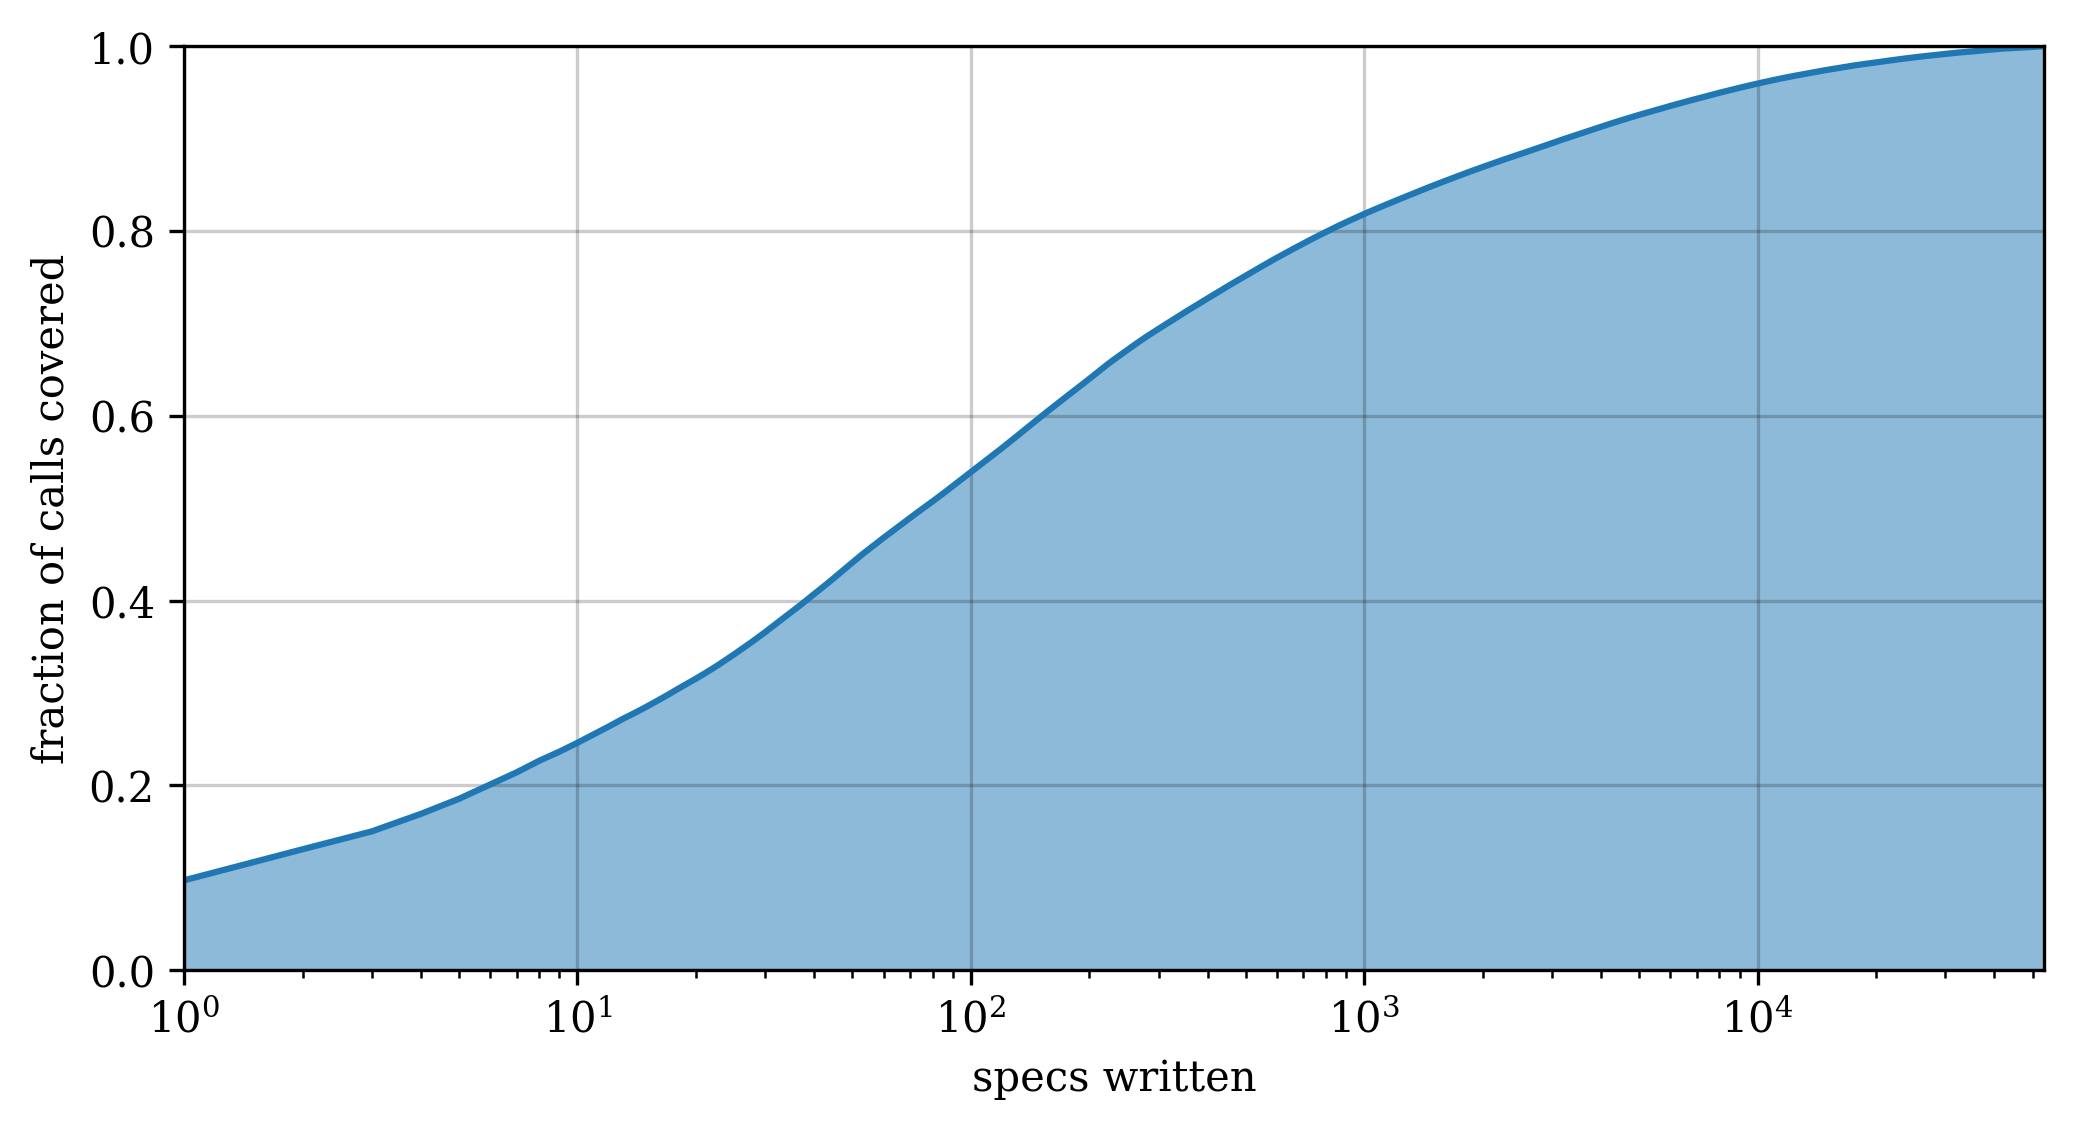

In [23]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.grid(color=(0, 0, 0), alpha=0.2)
ax.plot(cumulative_counts.index, cumulative_counts["total"])
ax.fill_between(cumulative_counts.index, cumulative_counts["total"], alpha=0.5)
plt.xlim(1, cumulative_counts.index.max())
plt.ylim(0, 1)
plt.xscale('log')
plt.ylabel("fraction of calls covered")
plt.xlabel("specs written")
plt.show()

In [24]:
counts = all_calls["count"]

def print_details(mask):
	masked = counts[mask]
	print(f"Calls: {masked.count()} / {counts.count()}")
	print(f"Occurrences: {masked.sum()} / {counts.sum()}")

print(f"< 10:")
print_details(counts < 10)
print()
print(f"> 1000:")
print_details(counts > 1000)

< 10:
Calls: 211843 / 266544
Occurrences: 591183 / 4317981

> 1000:
Calls: 388 / 266544
Occurrences: 1115303 / 4317981


In [25]:
by_target = sum_counts(all_calls, ['target', 'target_crate'])
by_target

,target,target_crate,count
0,core::ops::try_trait::FromResidual::from_residual,core,234749
1,core::ops::try_trait::Try::branch,core,234749
2,core::clone::Clone::clone,core,178200
3,quote::__private::push_ident,quote,144911
4,core::ops::deref::Deref::deref,core,137160
5,core::cmp::PartialEq::eq,core,112012
6,quote::to_tokens::ToTokens::to_tokens,quote,110666
7,core::default::Default::default,core,93281
8,core::iter::traits::iterator::Iterator::next,core,87474
9,core::fmt::Arguments::new_v1,core,83666


In [40]:
cumulative_by_target = by_target.copy()
compute_totals(cumulative_by_target)
print(len(cumulative_by_target[cumulative_by_target["total"] < 0.5]), len(cumulative_by_target))
print(len(cumulative_counts[cumulative_counts["total"] < 0.5]), len(cumulative_counts))

24 16061
76 53495


<AxesSubplot: >

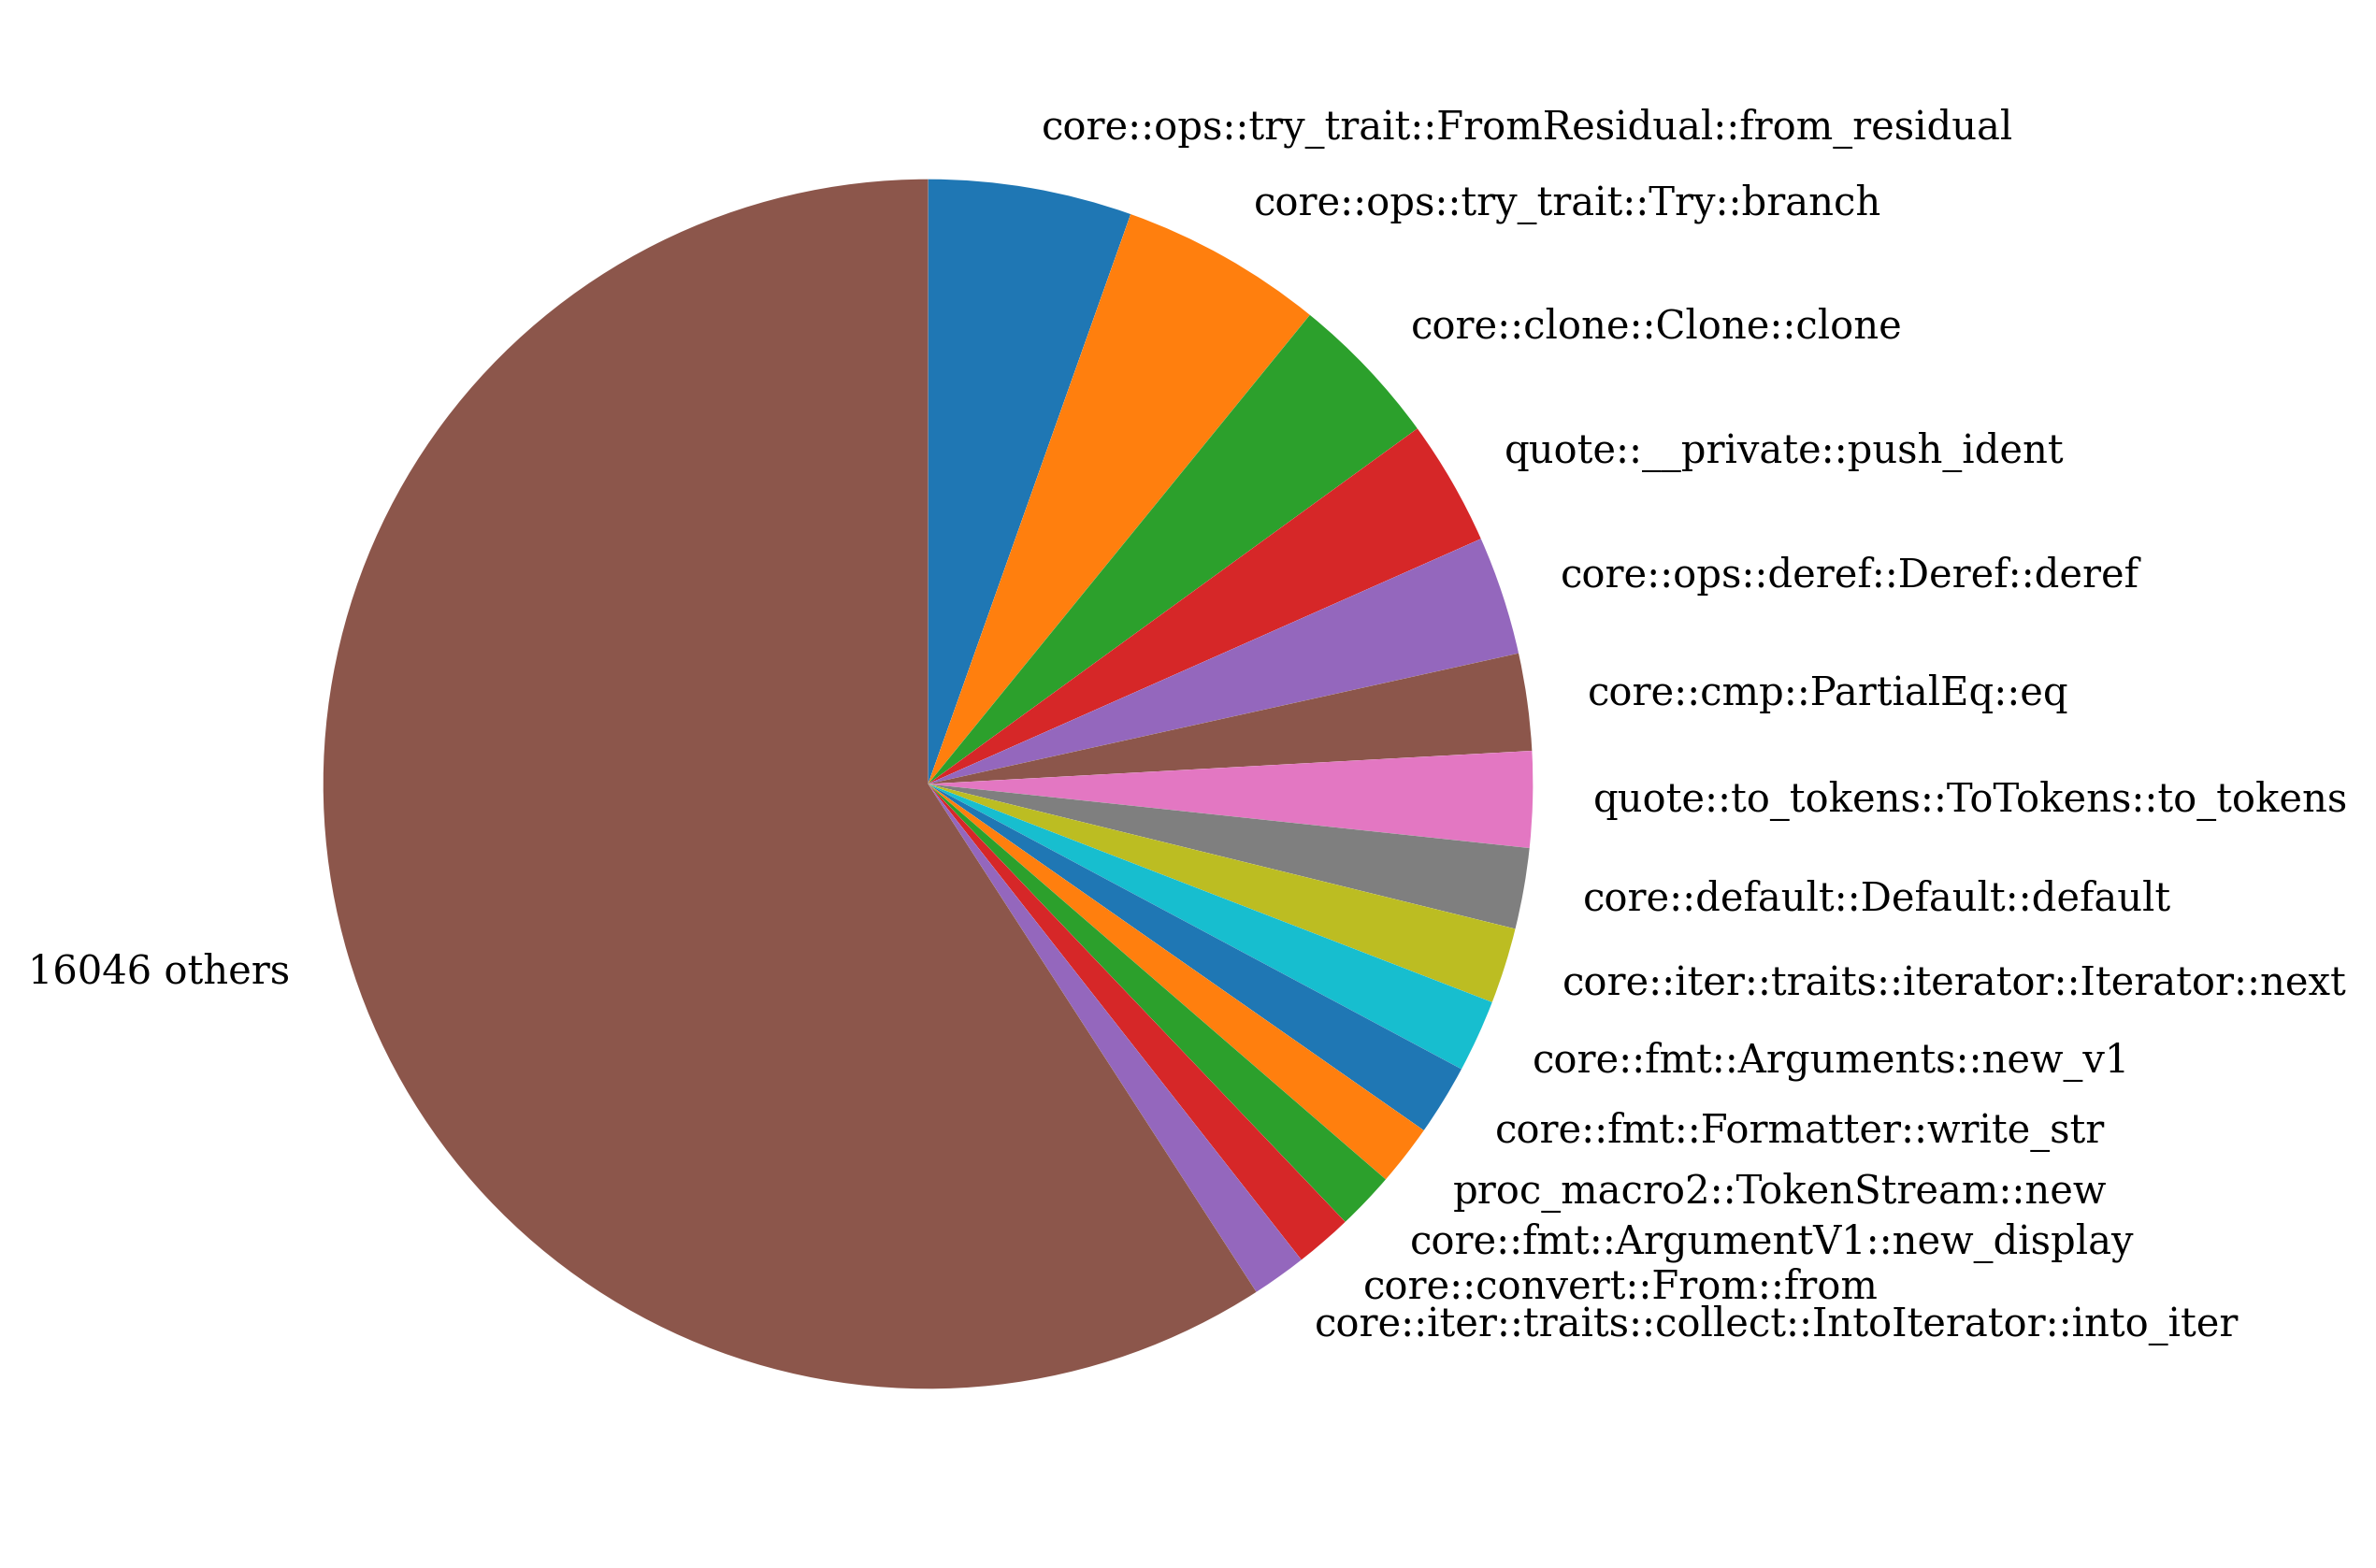

In [26]:
top_usage_counts = by_target.copy()
top_usage_counts.set_index('target', inplace=True)
cut_off_after_top(15, top_usage_counts)
top_usage_counts.plot(kind='pie', y='count', startangle=90, counterclock=False, rotatelabels=False, legend=False, ylabel='', figsize=(100, 7))

In [27]:
# print full list of most popular targets in a single crate

crate_filter = "core"
filtered = by_target[by_target['target_crate'] == crate_filter].reset_index(names='global_rank')
for i in range(min(100_000, len(filtered))):
	row = filtered.loc[i]
	print(f"{row['target']} - #{i + 1} (#{row['global_rank'] + 1} globally, {row['count']}x)")

core::ops::try_trait::FromResidual::from_residual - #1 (#1 globally, 234749x)
core::ops::try_trait::Try::branch - #2 (#2 globally, 234749x)
core::clone::Clone::clone - #3 (#3 globally, 178200x)
core::ops::deref::Deref::deref - #4 (#5 globally, 137160x)
core::cmp::PartialEq::eq - #5 (#6 globally, 112012x)
core::default::Default::default - #6 (#8 globally, 93281x)
core::iter::traits::iterator::Iterator::next - #7 (#9 globally, 87474x)
core::fmt::Arguments::new_v1 - #8 (#10 globally, 83666x)
core::fmt::Formatter::write_str - #9 (#11 globally, 81786x)
core::fmt::ArgumentV1::new_display - #10 (#13 globally, 66725x)
core::convert::From::from - #11 (#14 globally, 65948x)
core::iter::traits::collect::IntoIterator::into_iter - #12 (#15 globally, 62859x)
core::ops::index::Index::index - #13 (#17 globally, 50876x)
&[T]::len - #14 (#19 globally, 41430x)
core::hash::Hash::hash - #15 (#20 globally, 40712x)
core::fmt::builders::DebugStruct::field - #16 (#21 globally, 39731x)
core::convert::Into::into

In [28]:
by_crate = sum_counts(all_calls, ['target_crate']).set_index('target_crate')


<AxesSubplot: ylabel='count'>

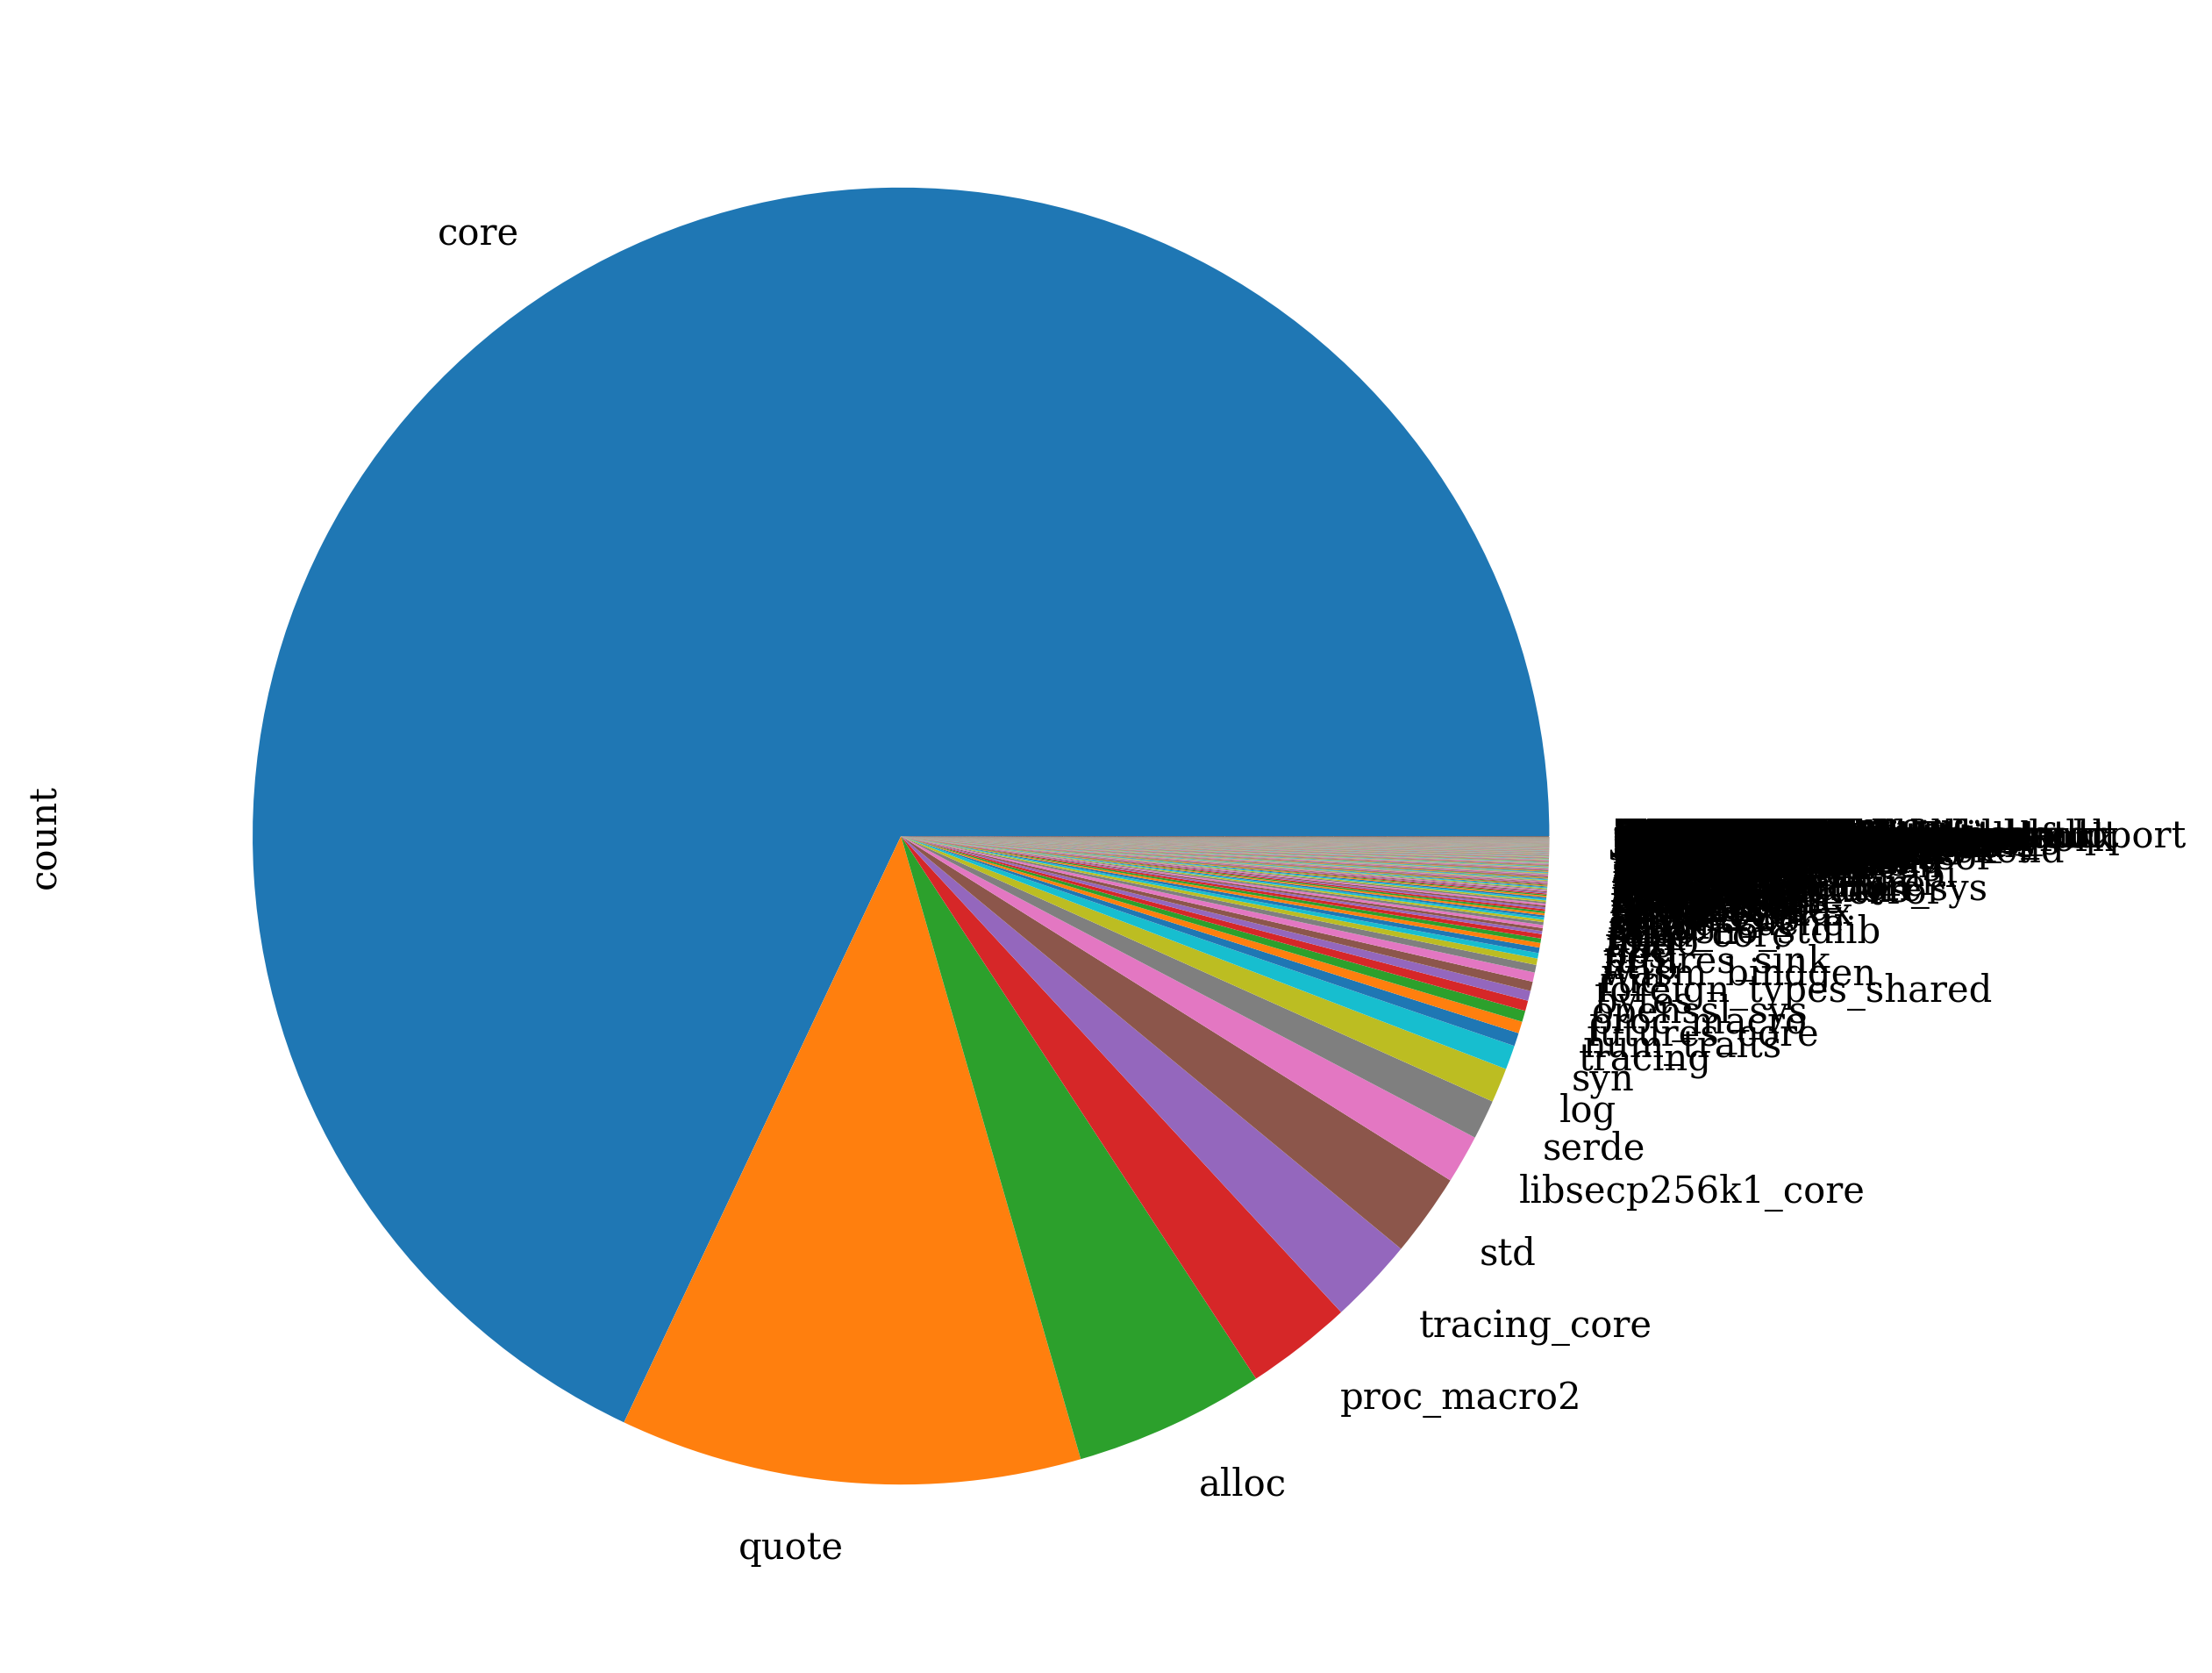

In [29]:
by_crate.plot(kind='pie', y='count', legend=False)

In [30]:
by_crate

,count
target_crate,
core,2935107
quote,496523
alloc,205126
proc_macro2,114573
tracing_core,92461
std,89532
libsecp256k1_core,52307
serde,42577
log,37250


In [31]:
crate_counts = by_crate.value_counts().sort_index()
crate_counts

count  
1          41
2          40
3          21
4          31
5          17
6          24
7          11
8          10
9           7
10         10
           ..
26005       1
37250       1
42577       1
52307       1
89532       1
92461       1
114573      1
205126      1
496523      1
2935107     1
Length: 244, dtype: int64